Author: Jonah So

email: jonahso@ucsb.edu

In [ ]:
pip install cudaq

In [1]:
!python --version

Python 3.13.5


In [2]:
import cudaq
import numpy as np
import time
import sys
from cudaq import spin
from cudaq import State
import matplotlib.pyplot as plt
from typing import List
# from plot_config import *

In [3]:
@cudaq.kernel
def get_initial_state(n_spins: int):
    """Create initial state |1010...>"""
    qubits = cudaq.qvector(n_spins)
    for i in range(0, n_spins, 2):
        x(qubits[i])

### First-Order Product Formula (PF1)

We can decompose the Hamiltonian as:

$
H = \sum_{l=1}^L H_l = \sum_{l=1}^L c_l P_l
$

where:
- $c_l \in \mathbb{R}$ are the coefficients,
- $P_l$ are Pauli words (tensor products of Pauli matrices).

The ideal time evolution operator is:
$
U(t) = e^{-i H t}
$

The first-order Trotter approximation replaces this by sequentially applying each term:
$
U(\delta t) \;\approx\; \prod_{l} e^{-i H_l \, \delta t}
$


### Second-order Product Formulas (PF2)
The second-order approximation is a combination of evolutions in both increasing and decreasing orders of indice.
More formally, we can write this as:

$
U(\delta t) \;\approx\; \prod_{l} e^{-i H_l \, \delta t / 2} \prod_{l} e^{-i H_l \, \delta t / 2}  
$

- Each term $H_l$ is applied twice with a half-step $\delta t / 2$.
- The first product applies the exponentials in increasing order of $l$.
- The second product applies them in decreasing order of $l$.

The following code creates the model that was used in the paper: **QIMF**

The hamiltonian is defined as the following:

$
H \;=\;
h_x \sum_{j=1}^N X_j \;+\;
h_y \sum_{j=1}^N Y_j \;+\;
J \sum_{j=1}^{N-1} X_j X_{j+1}
$

- $X_j, Y_j, Z_j$: Pauli operators on qubit \(j\).


In [4]:
def create_hamiltonian_qimf(n_spins: int, J: float, h_x: float, h_y: float):
    A = 0
    B = 0
    for j in range(n_spins - 1):
        A += J * spin.x(j) * spin.x(j + 1)

    for j in range(n_spins):
        A += h_x * spin.x(j)
        B += h_y * spin.y(j)

    return A, B, A+B

In [5]:
# H_pl = Power_Law(n=5, alpha=4, Jx=1, Jy=1, Jz=1, hx=1, hy=1, hz=1, pbc=False, verbose=True)
def create_powerlaw_hamiltonian(n_spins: int, Jx: float = 1.0, Jy: float = 1.0,
                                Jz: float = 1.0, h_x: float = 1.0, h_y: float = 1.0, h_z: float = 1.0, alpha: float = 4.0):
    A = 0
    B = 0
    for i in range(n_spins):
        for j in range(i + 1, n_spins):
            r = j - i
            A += (Jx / (r ** alpha)) * spin.x(i) * spin.x(j)
            A += (Jy / (r ** alpha)) * spin.y(i) * spin.y(j)
            A += (Jz / (r ** alpha)) * spin.z(i) * spin.z(j)

    for i in range(n_spins):
        B += h_x * spin.x(i)
        B += h_y * spin.y(i)
        B += h_z * spin.z(i)

    return A, B, A + B


### Trotter Approximation (PF1)
The time-evolution operator
$
e^{-i H \delta t}
$
 can be split into two non-commuting parts:

$
A = h_x \sum_j X_j \;+\; J \sum_j X_j X_{j+1},
\qquad
B = h_y \sum_j Y_j
$

so that the first-order Trotter step is:

$
\mathcal{U}_1(\delta t) \;\approx\; e^{-i A \delta t} \, e^{-i B \delta t}
$

In [6]:
@cudaq.kernel
def trotter_step_pf1 (state: cudaq.State, dt: float, c_a: List[complex], c_b: List[complex], words_a: List[cudaq.pauli_word], words_b: List[cudaq.pauli_word]):
    qubits = cudaq.qvector(state)

    for i in range(len(c_a)):
        exp_pauli(-c_a[i].real * dt, qubits, words_a[i])

    for i in range(len(c_b)):
        exp_pauli(-c_b[i].real * dt, qubits, words_b[i])


### Trotter Approximation (PF2)
Similar to PF1, we can define

$
U(\delta t) \;\approx\;
e^{-i A \, \tfrac{\delta t}{2}} \,
e^{-i B \, \delta t} \,
e^{-i A \, \tfrac{\delta t}{2}}
$

We apply all A-terms again with half timestep $\delta t / 2$, in reverse order for symmetry.

In [7]:
@cudaq.kernel
def trotter_step_pf2(state: cudaq.State, dt: float, c_a: List[complex], c_b: List[complex], words_a: List[cudaq.pauli_word], words_b: List[cudaq.pauli_word]):

    qubits = cudaq.qvector(state)

    for i in range(len(words_a)):
        exp_pauli(-c_a[i].real * (0.5*dt), qubits, words_a[i])

    for i in range(len(words_b)):
        exp_pauli(-c_b[i].real * dt, qubits, words_b[i])

    for i in range(len(words_a)-1, -1, -1):
        exp_pauli(-c_a[i].real * (0.5*dt), qubits, words_a[i])


Here, we extract coefficients and words from Hamiltonian for decomposition.

In [8]:
def extractCoefficients(hamiltonian: cudaq.SpinOperator):
    result = []
    for term in hamiltonian:
        result.append(term.get_coefficient())
        # print(term.get_coefficient())
    return result

def extractWords(hamiltonian: cudaq.SpinOperator):
    n_spins = hamiltonian.qubit_count
    result = []
    for term in hamiltonian:
        result.append(term.get_pauli_word(n_spins))
    return result

### Entropy Measure

Given a pure state $|\psi\rangle$ of an $n$-qubit system, the reduced density matrix for a subset of qubits $A$ is

$
\rho_A = \mathrm{Tr}_B \big( |\psi\rangle \langle \psi | \big),
$

where $B$ is the set of qubits traced out.

We can quantify its entanglement with the rest of the system by calculating von Neumann entropy:

$S(\rho) = - \text {Tr} [\rho \log \rho] = - \sum_i \lambda_i \log_2 \lambda_i$

where $\lambda_i$ are the eigenvalues of the reduced density matrix.

In [9]:
import cupy as cp
def partial_trace (psi: cp.ndarray, keep: List[int], n_qubits: int) -> cp.ndarray:
    psi = psi / cp.linalg.norm(psi)

    traced_out = [i for i in range(n_qubits) if i not in keep]
    dim_keep = 2 ** len(keep)
    dim_traced = 2 ** len(traced_out)
    psi = psi.reshape([2] * n_qubits)
    perm = keep + traced_out
    psi = psi.transpose(perm)
    psi = psi.reshape(dim_keep, dim_traced)

    rho_A = psi @ psi.conj().T
    return rho_A

In [29]:
def entropy(rho):
    eigvals = cp.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > 0]
    entropy = -cp.sum(eigvals * cp.log2(eigvals))
    return entropy.get() 

In [11]:
def purity(rho):
    return cp.real(cp.trace(rho @ rho)).item()

In [12]:
from cupyx.scipy.linalg import expm

def tro_U (A, B, dt):
    Am = cp.asarray(A.to_matrix(), dtype=cp.complex128)
    Bm = cp.asarray(B.to_matrix(), dtype=cp.complex128)
    U_a = expm(-1j * Am * dt)
    U_b = expm(-1j * Bm * dt)
    return U_a @ U_b

def tro_next_state(U, state):
    # return U_a @ (U_b @ state)
    return U @ state

In [13]:
import cupy as cp
from cupyx.scipy.linalg import expm

def ideal_U (H, dt):
    Hm = cp.asarray(H.to_matrix())
    return expm(-1j * Hm * dt)

def ideal_next_state(U, state):
    # psi = cp.asarray(state, dtype=cp.complex128)
    return U @ state

In [14]:
def trotter_error(psi_ideal, psi_trot):
    return ((cp.linalg.norm(psi_ideal - psi_trot)))

The following code is used for calculating the distance between the two density matrices represented by the state vectors. Use when phase change is not considered.

In [15]:
def trotter_error_dm (psi_ideal, psi_trotter):
    dm_ideal = cp.outer(psi_ideal, psi_ideal.conj())
    dm_trotter = cp.outer(psi_trotter, psi_trotter.conj())
    return (cp.linalg.norm(dm_ideal - dm_trotter))

Simulation with calculating trotter error between "ideal evolution" and trotterization.

In [16]:
def ideal_simulation (n_spins: int, cal: str, sub: int, initial_state: cudaq.State, ham: str, pf: int, r: int, h_x_val: float, h_y_val: float, J_val: float):
    n = n_spins
    ideal_state = initial_state
    i_state = initial_state
    t_state = initial_state

    out_list_ideal = []
    out_list_trotter = []

    time_list = []
    error_list = []

    dt = 0.1
    dt2 = 0.1
    r2 = 1
    m = 1

    subsystem = list(range(sub))

    h_x = np.full(n_spins, h_x_val)
    h_y = np.full(n_spins, h_y_val)
    h_z = np.zeros(n_spins)
    J = 1.0

    if ham == 'qimf':
        A, B, H = create_hamiltonian_qimf(n_spins, J=J_val, h_x=h_x_val, h_y=h_y_val)
        print(A)
    elif ham == 'powerlaw':
        A, B, H = create_powerlaw_hamiltonian(n_spins)
    else:
        print("invalid input")

    start_time = time.time()

    c_a = extractCoefficients(A)
    c_b = extractCoefficients(B)
    words_a = extractWords(A)
    words_b = extractWords(B)
    # Uncomment the line below for ideal evolution
    # U = ideal_U(H, dt)

    i_state = ideal_state
    for step in range(1, r + 1):
        # for _ in range(m + 1):
        #     i_state = cudaq.get_state(trotter_step_pf2, i_state, dt2, c_a, c_b, words_a, words_b)

        psi_t = cp.asarray(t_state, dtype=cp.complex128)
        ideal_state_new = cudaq.get_state(trotter_step_pf2, ideal_state, dt, c_a, c_b, words_a, words_b)

        t_state = cudaq.get_state(trotter_step_pf1, ideal_state, dt, c_a, c_b, words_a, words_b)

        ideal_state = ideal_state_new

        psi_ideal = cp.asarray(ideal_state, dtype=cp.complex128)
        psi_t = cp.asarray(t_state, dtype=cp.complex128)
        tro_error = trotter_error (psi_ideal, psi_t)

        out_list_ideal.append(psi_ideal)
        out_list_trotter.append(psi_t)
        time_list.append(dt * step)

    total_time = time.time() - start_time
    print(f"Simulation done in {total_time:.2f} seconds")
    # out_np_ideal= np.array([x.get() if hasattr(x, 'get') else x for x in out_list_ideal])
    # out_np_trotter = np.array([x.get() if hasattr(x, 'get') else x for x in out_list_trotter])

    return out_list_ideal, out_list_trotter 

In [32]:
n = 12
r = 100
initial_state = cudaq.get_state(get_initial_state, n)
ham = 'qimf'
subsystem = 4
t_list = np.linspace(0, 10, 100)
# y_ticks = [0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013]
# y_ticks = [0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14]
# y_ticks = [0.05, 0.075, 0.1, 0.125, 0.15]

h_x_val, h_y_val, J_val = 0.8090, 0.9045, 1
pf = 2

ideal, trotter = ideal_simulation (n, 'entropy', subsystem, initial_state, ham, pf, r, h_x_val, h_y_val, J_val) 

tro_error = [] 
for i in range (r): 
    tro = trotter_error (ideal[i], trotter[i])
    tro_error.append(tro.get()) 

(0+0i) + (1+0i) * X0X1 + (1+0i) * X1X2 + (1+0i) * X2X3 + (1+0i) * X3X4 + (1+0i) * X4X5 + (1+0i) * X5X6 + (1+0i) * X6X7 + (1+0i) * X7X8 + (1+0i) * X8X9 + (1+0i) * X9X10 + (1+0i) * X10X11 + (0.809+0i) * X0 + (0.809+0i) * X1 + (0.809+0i) * X2 + (0.809+0i) * X3 + (0.809+0i) * X4 + (0.809+0i) * X5 + (0.809+0i) * X6 + (0.809+0i) * X7 + (0.809+0i) * X8 + (0.809+0i) * X9 + (0.809+0i) * X10 + (0.809+0i) * X11


/tmp/ipykernel_1346075/2752899659.py:4: DeprecationWarning: use `evaluate_coefficient` instead
  result.append(term.get_coefficient())


Simulation done in 0.32 seconds


In [33]:
entropy_list, entropy_list2 = [], [] 

for i in range (r): 
    rdm1 = partial_trace(ideal[i], list(range(1)), n_qubits=n)
    rdm2 = partial_trace(ideal[i], list(range(2)), n_qubits=n)
    rdm3 = partial_trace(ideal[i], list(range(3)), n_qubits=n)
    rdm4 = partial_trace(ideal[i], list(range(4)), n_qubits=n)

    temp = [entropy(rdm1), entropy(rdm2), entropy(rdm3), entropy(rdm4)]
    # print(temp)

    trdm1 = partial_trace(trotter[i], list(range(1)), n_qubits=n)
    trdm2 = partial_trace(trotter[i], list(range(2)), n_qubits=n)
    trdm3 = partial_trace(trotter[i], list(range(3)), n_qubits=n)
    trdm4 = partial_trace(trotter[i], list(range(4)), n_qubits=n)
    temp2 = [entropy(trdm1), entropy(trdm2), entropy(trdm3), entropy(trdm4)]

    entropy_list.append(temp) 
    entropy_list2.append(temp2) 

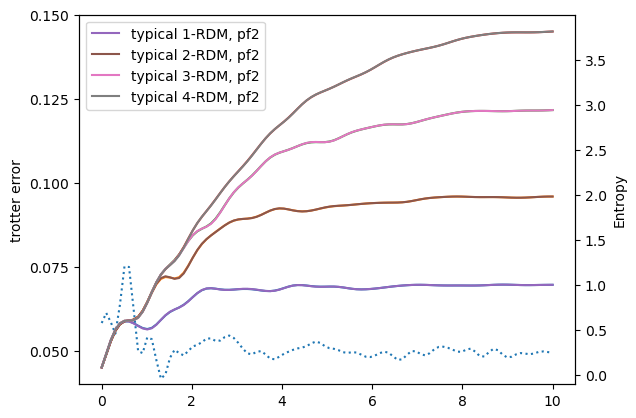

In [45]:
import matplotlib.pyplot as plt
import numpy as np

dt = 0.1
steps = len(entropy_list)
times = np.linspace(0, 10, 100)

entropy_values_1 = [entropy[0] for entropy in entropy_list]
entropy_values_2 = [entropy[1] for entropy in entropy_list]
entropy_values_3 = [entropy[2] for entropy in entropy_list]
entropy_values_4 = [entropy[3] for entropy in entropy_list]

entropy_values_12 = [entropy[0] for entropy in entropy_list2]
entropy_values_22 = [entropy[1] for entropy in entropy_list2]
entropy_values_32 = [entropy[2] for entropy in entropy_list2]
entropy_values_42 = [entropy[3] for entropy in entropy_list2]


fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True)
ax2 = axes.twinx() 
# Create the plot
ax2.plot(times, entropy_values_1)
ax2.plot(times, entropy_values_2)
ax2.plot(times, entropy_values_3)
ax2.plot(times, entropy_values_4) 
ax2.plot(times, entropy_values_12, label='typical 1-RDM, pf2')
ax2.plot(times, entropy_values_22, label='typical 2-RDM, pf2')
ax2.plot(times, entropy_values_32, label='typical 3-RDM, pf2')
ax2.plot(times, entropy_values_42, label='typical 4-RDM, pf2')

axes.plot(times, tro_error, linestyle=":") 
y_ticks = [0.05, 0.075, 0.1, 0.125, 0.15] 
axes.set_yticks(y_ticks) 
axes.set_ylabel("trotter error") 

ax2.set_xlabel("Time")
ax2.set_ylabel("Entropy")
ax2.legend()